# 別々のアンサーデータごとに予測するための異常ラベル作成

In [1]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 自作関数
from dataload.data_load import data_load
from func.my_func import *

In [2]:
keio_df = pd.read_csv('../../../野球部データ収集/keio_data/keio.csv', parse_dates=[1])
use_feature_df = keio_df[['UserID', 'TargetDate', 'Score', 'DiffRestHrValue', 'DiffWakedHrValue',
        'StressCount', 'DeepSleepRate', 'LowActivityHourws']]

answer_df = pd.read_csv('../../../野球部データ収集/keio_data/keio_answer_data.csv', parse_dates=[1])
category = pd.read_csv('../../../野球部データ収集/keio_data/category.csv', encoding='shift-jis')
answer_df = answer_df.merge(category)

## 各値3以上の入力を異常として定義
- 5：痛みがある
- 4：重みがある
- 3：ハリがある
- 2：違和感がある
- 1：異常なし


category,TargetDate,下肢の状態,肘の状態,肩の状態
0,2022-02-18,3,1,2
1,2022-02-19,3,2,2
2,2022-02-20,3,1,1
3,2022-02-21,3,3,3
4,2022-02-22,3,1,3
...,...,...,...,...
82,2022-05-31,1,4,3
83,2022-06-01,5,3,3
84,2022-06-06,4,1,1
85,2022-06-07,5,1,1


category
下肢の状態    66
肘の状態     22
肩の状態     30
dtype: int64


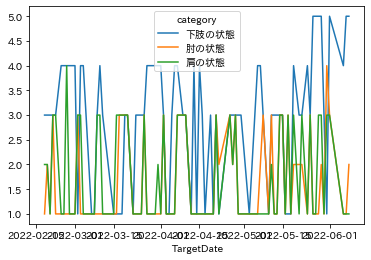

category,TargetDate,下肢の状態,肘の状態,肩の状態
0,2022-02-24,4,4,4
1,2022-02-25,1,4,1
2,2022-02-26,4,3,3
3,2022-02-27,3,3,3
4,2022-02-28,3,4,3
...,...,...,...,...
84,2022-06-01,1,1,1
85,2022-06-05,1,1,1
86,2022-06-06,1,1,1
87,2022-06-07,1,1,1


category
下肢の状態    23
肘の状態     16
肩の状態     13
dtype: int64


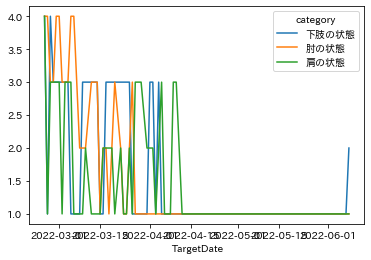

category,TargetDate,下肢の状態,肘の状態,肩の状態
0,2022-02-24,3,1,1
1,2022-02-25,3,1,1
2,2022-02-26,3,1,3
3,2022-02-27,2,1,1
4,2022-02-28,2,1,1
...,...,...,...,...
82,2022-06-02,1,1,1
83,2022-06-05,1,1,1
84,2022-06-06,1,1,1
85,2022-06-07,3,1,1


category
下肢の状態    10
肘の状態      1
肩の状態      3
dtype: int64


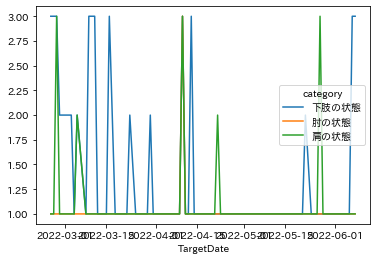

category,TargetDate,下肢の状態,肘の状態,肩の状態
0,2022-02-24,4,1,1
1,2022-02-25,1,1,4
2,2022-02-26,1,1,4
3,2022-02-27,1,1,4
4,2022-02-28,3,1,4
...,...,...,...,...
100,2022-06-04,1,1,1
101,2022-06-05,1,1,1
102,2022-06-06,1,1,1
103,2022-06-07,1,1,1


category
下肢の状態    20
肘の状態     11
肩の状態      5
dtype: int64


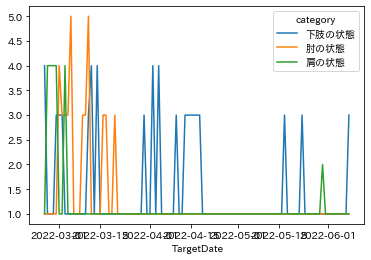

category,TargetDate,下肢の状態,肘の状態,肩の状態
0,2022-02-25,3,1,1
1,2022-02-26,3,3,3
2,2022-02-27,3,3,3
3,2022-02-28,3,3,3
4,2022-03-01,4,3,3
...,...,...,...,...
81,2022-06-01,1,1,1
82,2022-06-05,1,1,1
83,2022-06-06,1,1,1
84,2022-06-07,1,1,1


category
下肢の状態    34
肘の状態     32
肩の状態     34
dtype: int64


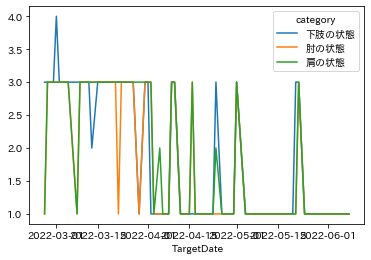

In [3]:
# どのくらい異常があるのかの確認
users = [
    1505, 
    1755, 
    1781, 
    1774, 
    1773
]
for user_id in users:
    _piv_df = answer_df[answer_df['UserID'] == user_id].pivot_table(
            values='value',
            index='TargetDate',
            columns='category'
        ).reset_index()
    _piv_df['TargetDate'] = _piv_df['TargetDate'].dt.date
    _piv_df = _piv_df.drop(['体温', '朝食'], axis=1)
    display(_piv_df)
    print((_piv_df.set_index('TargetDate') > 2).sum())
    _piv_df.set_index('TargetDate').plot()
    plt.show()

In [4]:
_piv_df

category,TargetDate,下肢の状態,肘の状態,肩の状態
0,2022-02-25,3,1,1
1,2022-02-26,3,3,3
2,2022-02-27,3,3,3
3,2022-02-28,3,3,3
4,2022-03-01,4,3,3
...,...,...,...,...
81,2022-06-01,1,1,1
82,2022-06-05,1,1,1
83,2022-06-06,1,1,1
84,2022-06-07,1,1,1


## user_idを入力するとラベルと目的変数を出力する関数を作成．

In [12]:
def create_y(user_id):
    _piv_df = answer_df[answer_df['UserID'] == user_id].pivot_table(
        values='value',
        index='TargetDate',
        columns='category'
    ).reset_index()
    _piv_df['TargetDate'] = _piv_df['TargetDate'].dt.date
    _piv_df = _piv_df.drop(['体温', '朝食'], axis=1)
    for i in ['下肢の状態',	'肘の状態', '肩の状態']:
        _piv_df[f'y_{i}'] = _piv_df[i].apply(lambda x: int(x > 2))
    return _piv_df
create_y(user_id)

category,TargetDate,下肢の状態,肘の状態,肩の状態,y_下肢の状態,y_肘の状態,y_肩の状態
0,2022-02-25,3,1,1,1,0,0
1,2022-02-26,3,3,3,1,1,1
2,2022-02-27,3,3,3,1,1,1
3,2022-02-28,3,3,3,1,1,1
4,2022-03-01,4,3,3,1,1,1
...,...,...,...,...,...,...,...
81,2022-06-01,1,1,1,0,0,0
82,2022-06-05,1,1,1,0,0,0
83,2022-06-06,1,1,1,0,0,0
84,2022-06-07,1,1,1,0,0,0
